In [1]:
import os
import sys
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
sys.path.append('yolov4-TT100k')
print([f for f in os.listdir('.') if os.path.isfile(f)])
from nets.yolo4 import YoloBody
from nets.yolo_training import LossHistory, YOLOLoss, weights_init
# from utils.dataloader import YoloDataset, yolo_dataset_collate
from utils.coco import COCO, yolo_dataset_collate, COCOEval
from utils.utilss import DecodeBox, non_max_suppression, add_weight_decay, setup_seed
from utils.summary import Summary
import shutil
%load_ext autoreload
%autoreload 2

c:\Users\Eachann\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['annotations_all.json', 'anno_func.py', 'mAP.png', 'marks.jpg', 'mmAP.png', 'mymymy.ipynb', 'output.png', 'output_largelr.png', 'ploter.ipynb', 'report.pdf', 'test.ipynb', 'test_result.pkl', 'Train.ipynb', 'train_liss.npy', 'tt100k_151_classes.txt', 'TT100K_CoCo_format_151_test.json', 'TT100K_CoCo_format_train.json', 'vali_liss.npy']
['annotations_all.json', 'anno_func.py', 'mAP.png', 'marks.jpg', 'mmAP.png', 'mymymy.ipynb', 'output.png', 'output_largelr.png', 'ploter.ipynb', 'report.pdf', 'test.ipynb', 'test_result.pkl', 'Train.ipynb', 'train_liss.npy', 'tt100k_151_classes.txt', 'TT100K_CoCo_format_151_test.json', 'TT100K_CoCo_format_train.json', 'vali_liss.npy']
************************************************************


## Data processing

In [2]:


yolo_decodes = []
confidence = 0.01
iou = 0.5
g_steps = 0
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names


def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape([-1, 3, 2])[::-1, :, :]


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_epoch(net, yolo_loss, epoch, epoch_size, epoch_size_val, gen, genval, Epoch, cuda):#Training with 1 epoch 
    total_loss = 0
    val_loss = 0
    train_loss = []
    net.train()
    print('Start Train')
    with tqdm(total=epoch_size, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_size:
                break
            # images, targets = batch[0], batch[1]
            img_ids, images, targets = batch[0], batch[1], batch[2]
            with torch.no_grad():#load imgs
                if cuda:
                    images = torch.from_numpy(images).type(torch.FloatTensor).cuda()
                    targets = [torch.from_numpy(ann).type(torch.FloatTensor) for ann in targets]
                else:
                    images = torch.from_numpy(images).type(torch.FloatTensor)
                    targets = [torch.from_numpy(ann).type(torch.FloatTensor) for ann in targets]
            optimizer.zero_grad()
            outputs = net(images)
            losses = []
            num_pos_all = 0
            for i in range(3):
                loss_item, num_pos = yolo_loss(outputs[i], targets)
                losses.append(loss_item)
                num_pos_all += num_pos

            loss = sum(losses) / num_pos_all
            total_loss += loss.item()
            train_loss += [loss.item()]
            loss.backward()
            optimizer.step()
            summary.add_scalar('train/total_loss', total_loss / (iteration + 1), epoch * epoch_size + iteration)
            pbar.set_postfix(**{'total_loss': total_loss / (iteration + 1),
                                'lr': get_lr(optimizer)})
            pbar.update(1)
    net.eval()
    print('Start Validation')
    with torch.no_grad():
        img_ids = []
        detections = []
        with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
            for iteration, batch in enumerate(genval):
                if iteration >= epoch_size_val:
                    break
                # images_val, targets_val = batch[0], batch[1]
                img_ids_val, images_val, targets_val = batch[0], batch[1], batch[2]

                with torch.no_grad():
                    if cuda:
                        images_val = torch.from_numpy(images_val).type(torch.FloatTensor).cuda()
                        targets_val = [torch.from_numpy(ann).type(torch.FloatTensor) for ann in targets_val]
                    else:
                        images_val = torch.from_numpy(images_val).type(torch.FloatTensor)
                        targets_val = [torch.from_numpy(ann).type(torch.FloatTensor) for ann in targets_val]
                    optimizer.zero_grad()

                    outputs = net(images_val)
                    output_list = []
                    for ii in range(3):
                        output_list.append(yolo_decodes[ii](outputs[ii]))

                    output = torch.cat(output_list, 1)
                    batch_detections = non_max_suppression(output, num_classes, conf_thres=confidence,
                                                           nms_thres=iou)
                    img_ids += img_ids_val
                    detections += batch_detections

                    losses = []
                    num_pos_all = 0
                    for i in range(3):
                        loss_item, num_pos = yolo_loss(outputs[i], targets_val)
                        losses.append(loss_item)
                        num_pos_all += num_pos
                    loss = sum(losses) / num_pos_all
                    val_loss += loss.item()
                summary.add_scalar('val/total_loss', val_loss / (iteration + 1), epoch * epoch_size + iteration)
                pbar.set_postfix(**{'total_loss': val_loss / (iteration + 1)})
                pbar.update(1)
        
        loss_history.append_loss(total_loss / (epoch_size + 1), val_loss / (epoch_size_val + 1))
        eval_results = val_dataset.run_eval(img_ids, detections)
       # print('MAP',eval_results[0])
        summary.add_scalar('val/mAP', eval_results[0], epoch + 1)

        print('Finish Validation')
        print('Epoch:' + str(epoch + 1) + '/' + str(Epoch))
        print(eval_results)
        print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss / (epoch_size + 1), val_loss / (epoch_size_val + 1)))

        net_save_path = os.path.join(os.path.join(exp_dir, "ckpt"), "model_latest.pth")
        net_save_path_best = os.path.join(os.path.join(exp_dir, "ckpt"), "model_best.pth")

        save_best = False
        if eval_results[0] >= metrics['mAP']:
            save_best = True
            metrics['train_loss'] = total_loss / (epoch_size + 1)
            metrics['val_loss'] = val_loss / (epoch_size_val + 1)
            metrics['mAP'] = eval_results[0]
            metrics['best_model_epoch'] = epoch + 1
            print('Saving state, iter:', str(epoch + 1))

        torch.save({"state_dict": model.state_dict(),
                    "metric": metrics}
                   , net_save_path)

        if save_best:
            shutil.copy(net_save_path, net_save_path_best)
            print("Saving current best: {}, metric:{}".format(net_save_path_best, metrics))

        print("@@@ best metric:{}".format(net_save_path_best, metrics))
    return total_loss / (epoch_size + 1), val_loss / (epoch_size_val + 1),eval_results[0]


In [3]:

setup_seed(1215)
Cuda = True
normalize = False
# input_shape = (416, 416)
input_shape = (608, 608)
anchors_path = 'yolov4-TT100k/model_data/yolo_anchors.txt'
classes_path = 'yolov4-TT100k/model_data/tt100k_151_classes.txt'
mosaic = False
Cosine_lr = True
smoooth_label = 0.005
weight_decay = 0#1e-5
metrics = {'mAP': 0, 'train_loss': float('inf'), 'val_loss': float('inf'), 'best_model_epoch': 0}
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)
num_classes = len(class_names)

# ----------------------------------------------------#

for i in range(3):
    yolo_decodes.append(
        DecodeBox(anchors[i], num_classes, (input_shape[1], input_shape[0])))

model = YoloBody(len(anchors[0]), num_classes)
weights_init(model)


#model_path = "model_data/yolo4_weights.pth"
#model_path = "exp/exp_baseline/ckpt/model_best.pth"
model_path =  'yolov4-TT100k/model_data/model_best.pth'
print('Loading weights into state dict...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device',device)
model_dict = model.state_dict()
pretrained_dict = torch.load(model_path, map_location=device)["state_dict"]
pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) == np.shape(v)}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
print('Finished!')

net = model.train()

if Cuda:
    net = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    net = net.cuda()

yolo_loss = YOLOLoss(np.reshape(anchors, [-1, 2]), num_classes, (input_shape[1], input_shape[0]), smoooth_label,
                        Cuda, normalize)
exp_dir = "./exp/exp_baseline_mosaic"
loss_history = LossHistory(exp_dir)
summary = Summary(os.path.join(exp_dir, "summary"))
ckpt = os.path.join(exp_dir, "ckpt")
if not os.path.exists(ckpt):
    os.makedirs(ckpt)

if Cuda:
    graph_inputs = torch.randn(1, 3, input_shape[0], input_shape[1]).type(torch.FloatTensor).cuda()
else:
    graph_inputs = torch.randn(1, 3, input_shape[0], input_shape[1]).type(torch.FloatTensor)
summary.add_graph(model, graph_inputs)





initialize network with normal type
Loading weights into state dict...
device cuda
Finished!


In [4]:
data_dir = "../tt100k/"
lr = 1e-3
Batch_size = 3
Init_Epoch = 0
Freeze_Epoch = 50
parameters = add_weight_decay(net, weight_decay)
optimizer = optim.Adam(parameters, lr)
# optimizer = optim.Adam(net.parameters(), lr)

if Cosine_lr:
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
else:
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.92)

train_dataset = COCO(data_dir, (input_shape[0], input_shape[1]), mosaic=mosaic)
val_dataset = COCOEval(data_dir, (input_shape[0], input_shape[1]))
# train_dataset = YoloDataset(lines[:num_train], (input_shape[0], input_shape[1]), mosaic=mosaic, is_train=True)
# val_dataset = YoloDataset(lines[num_train:], (input_shape[0], input_shape[1]), mosaic=False, is_train=False)
gen = DataLoader(train_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                    drop_last=True, collate_fn=yolo_dataset_collate)
gen_val = DataLoader(val_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                        drop_last=True, collate_fn=yolo_dataset_collate)

epoch_size = len(train_dataset) // Batch_size
epoch_size_val = len(val_dataset) // Batch_size

#Freeze param
for param in model.backbone.parameters():
    param.requires_grad = False#change here
train_loss = [-999]* Freeze_Epoch
vali_loss = [-999]* Freeze_Epoch
maps = []
for epoch in range(Init_Epoch, Freeze_Epoch):
    train_loss[epoch],vali_loss[epoch],one_map = fit_one_epoch(net, yolo_loss, epoch, epoch_size, epoch_size_val, gen, gen_val, Freeze_Epoch, Cuda)
    maps += [one_map]
    lr_scheduler.step()

# Releases all unoccupied cached memory
torch.cuda.empty_cache()


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Start Train


Epoch 1/100: 100%|██████████| 2011/2011 [13:29<00:00,  2.48it/s, lr=0.0001, total_loss=3.14]


Start Validation


Epoch 1/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.53it/s, total_loss=6.46]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.94s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 2/100: 100%|██████████| 2011/2011 [13:25<00:00,  2.50it/s, lr=9.14e-5, total_loss=2.69]


Start Validation


Epoch 2/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.54it/s, total_loss=6.17]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.60s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 3/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.52]


Start Validation


Epoch 3/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.99]


Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.77s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 4/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=2.28]


Start Validation


Epoch 4/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.64]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.84s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 5/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=2.14]


Start Validation


Epoch 5/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.61]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.53s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 6/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=1e-5, total_loss=2.11]


Start Validation


Epoch 6/100: 100%|██████████| 1005/1005 [02:35<00:00,  6.48it/s, total_loss=5.63]


Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.80s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 7/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=1.86e-5, total_loss=2.07]


Start Validation


Epoch 7/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.72]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.80s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 8/100: 100%|██████████| 2011/2011 [13:25<00:00,  2.50it/s, lr=4.11e-5, total_loss=2.1] 


Start Validation


Epoch 8/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=5.83]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.50s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 9/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.21]


Start Validation


Epoch 9/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.53it/s, total_loss=5.9] 


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.77s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 10/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.38]


Start Validation


Epoch 10/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=6.03]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.69s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 11/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=0.0001, total_loss=2.44]


Start Validation


Epoch 11/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=6.06]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.02s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 12/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.39]


Start Validation


Epoch 12/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=6.11]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.59s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 13/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.21]


Start Validation


Epoch 13/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.88]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.85s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 14/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=2]   


Start Validation


Epoch 14/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.88]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.66s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 15/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.97]


Start Validation


Epoch 15/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.73]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.05s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 16/100: 100%|██████████| 2011/2011 [13:28<00:00,  2.49it/s, lr=1e-5, total_loss=1.87]


Start Validation


Epoch 16/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.7] 


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.60s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 17/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.88]


Start Validation


Epoch 17/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.76]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.71s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 18/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.89]


Start Validation


Epoch 18/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.69]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.13s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 19/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.09]


Start Validation


Epoch 19/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.94]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.68s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 20/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.23]


Start Validation


Epoch 20/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=6.23]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.82s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 21/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=0.0001, total_loss=2.31]


Start Validation


Epoch 21/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=6.01]
yolov4-TT100k\nets\yolo_training.py:493: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.71s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 22/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.24]


Start Validation


Epoch 22/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=6.23]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.99s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 23/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.11]


Start Validation


Epoch 23/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.94]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.05s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 24/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.95]


Start Validation


Epoch 24/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.84]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.71s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 25/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.87]


Start Validation


Epoch 25/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.72]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.61s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 26/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1e-5, total_loss=1.77]


Start Validation


Epoch 26/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.69]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.01s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 27/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.78]


Start Validation


Epoch 27/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.72]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.67s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 28/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.83]


Start Validation


Epoch 28/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.68]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.12s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 29/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=6.89e-5, total_loss=1.94]


Start Validation


Epoch 29/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=6.01]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.88s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 30/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.15]


Start Validation


Epoch 30/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=6.21]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.86s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 31/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=0.0001, total_loss=2.13]


Start Validation


Epoch 31/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=6.17]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.07s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 32/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.08]


Start Validation


Epoch 32/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.49it/s, total_loss=6.01]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.95s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 33/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=2.02]


Start Validation


Epoch 33/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.91]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.92s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 34/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.87]


Start Validation


Epoch 34/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.87]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.07s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 35/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.74]


Start Validation


Epoch 35/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.82]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.05s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 36/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=1e-5, total_loss=1.66]


Start Validation


Epoch 36/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.54it/s, total_loss=5.72]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.82s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 37/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.73]


Start Validation


Epoch 37/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.49it/s, total_loss=5.74]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.81s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 38/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.75]


Start Validation


Epoch 38/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.49it/s, total_loss=5.89]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.72s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 39/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=1.9] 


Start Validation


Epoch 39/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=6.11]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.12s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 40/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.04]


Start Validation


Epoch 40/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.55it/s, total_loss=6.18]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.80s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 41/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=0.0001, total_loss=2.06]


Start Validation


Epoch 41/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=6.04]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.97s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 42/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=2.06]


Start Validation


Epoch 42/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=5.89]


Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.00s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 43/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=6.89e-5, total_loss=1.9] 


Start Validation


Epoch 43/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.89]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.22s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 44/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.84]


Start Validation


Epoch 44/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.77]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.89s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 45/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.7] 


Start Validation


Epoch 45/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=5.69]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.84s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 46/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1e-5, total_loss=1.63]


Start Validation


Epoch 46/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.74]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.15s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 47/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=1.86e-5, total_loss=1.66]


Start Validation


Epoch 47/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.82]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.08s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 48/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.72]


Start Validation


Epoch 48/100: 100%|██████████| 1005/1005 [02:33<00:00,  6.53it/s, total_loss=5.87]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.88s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 49/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=6.89e-5, total_loss=1.85]


Start Validation


Epoch 49/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.52it/s, total_loss=6.2] 


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.88s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 50/100: 100%|██████████| 2011/2011 [13:27<00:00,  2.49it/s, lr=9.14e-5, total_loss=1.89]


Start Validation


Epoch 50/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.49it/s, total_loss=6.07]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.06s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 51/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=0.0001, total_loss=1.97]


Start Validation


Epoch 51/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.51it/s, total_loss=5.96]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.82s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 52/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=9.14e-5, total_loss=1.99]


Start Validation


Epoch 52/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=6.15]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.02s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 53/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=6.89e-5, total_loss=1.83]


Start Validation


Epoch 53/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.50it/s, total_loss=5.94]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.10s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 54/100: 100%|██████████| 2011/2011 [13:26<00:00,  2.49it/s, lr=4.11e-5, total_loss=1.74]


Start Validation


Epoch 54/100: 100%|██████████| 1005/1005 [02:34<00:00,  6.49it/s, total_loss=5.86]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.32s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 55/100: 100%|██████████| 2011/2011 [12:54<00:00,  2.60it/s, lr=1.86e-5, total_loss=1.64]


Start Validation


Epoch 55/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.86it/s, total_loss=5.76]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.87s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 56/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=1e-5, total_loss=1.58]


Start Validation


Epoch 56/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=5.76]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.98s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 57/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=1.86e-5, total_loss=1.62]


Start Validation


Epoch 57/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.85it/s, total_loss=5.83]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.85s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 58/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=4.11e-5, total_loss=1.64]


Start Validation


Epoch 58/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=6.07]


Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.09s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 59/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=6.89e-5, total_loss=1.73]


Start Validation


Epoch 59/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=6.11]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.87s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 60/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=9.14e-5, total_loss=1.88]


Start Validation


Epoch 60/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.88it/s, total_loss=6.04]


Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.25s).
Accumulating evaluation results...
DONE (t=1.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 61/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=0.0001, total_loss=1.95]


Start Validation


Epoch 61/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.93it/s, total_loss=5.97]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.85s).
Accumulating evaluation results...
DONE (t=1.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 62/100: 100%|██████████| 2011/2011 [12:50<00:00,  2.61it/s, lr=9.14e-5, total_loss=1.87]


Start Validation


Epoch 62/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.94it/s, total_loss=6.06]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.25s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 63/100: 100%|██████████| 2011/2011 [12:50<00:00,  2.61it/s, lr=6.89e-5, total_loss=1.83]


Start Validation


Epoch 63/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.94it/s, total_loss=5.99]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.69s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 64/100: 100%|██████████| 2011/2011 [12:50<00:00,  2.61it/s, lr=4.11e-5, total_loss=1.64]


Start Validation


Epoch 64/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.91it/s, total_loss=5.9] 


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.39s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 65/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1.86e-5, total_loss=1.6] 


Start Validation


Epoch 65/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.79]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.66s).
Accumulating evaluation results...
DONE (t=1.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 66/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1e-5, total_loss=1.56]


Start Validation


Epoch 66/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.93it/s, total_loss=5.79]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.00s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 67/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1.86e-5, total_loss=1.56]


Start Validation


Epoch 67/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.94it/s, total_loss=5.73]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.36s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 68/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=4.11e-5, total_loss=1.59]


Start Validation


Epoch 68/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.69]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.06s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 69/100: 100%|██████████| 2011/2011 [12:50<00:00,  2.61it/s, lr=6.89e-5, total_loss=1.74]


Start Validation


Epoch 69/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.93it/s, total_loss=6.16]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.67s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 70/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=9.14e-5, total_loss=1.86]


Start Validation


Epoch 70/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.91it/s, total_loss=6.05]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.41s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 71/100: 100%|██████████| 2011/2011 [12:50<00:00,  2.61it/s, lr=0.0001, total_loss=1.96]


Start Validation


Epoch 71/100: 100%|██████████| 1005/1005 [02:24<00:00,  6.94it/s, total_loss=6.44]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.72s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 72/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=9.14e-5, total_loss=1.9] 


Start Validation


Epoch 72/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.87]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.09s).
Accumulating evaluation results...
DONE (t=1.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 73/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=6.89e-5, total_loss=1.76]


Start Validation


Epoch 73/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=5.82]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.19s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 74/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=4.11e-5, total_loss=1.63]


Start Validation


Epoch 74/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.71]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.08s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 75/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1.86e-5, total_loss=1.57]


Start Validation


Epoch 75/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=5.77]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.95s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 76/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1e-5, total_loss=1.5] 


Start Validation


Epoch 76/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.71]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.20s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 77/100: 100%|██████████| 2011/2011 [12:51<00:00,  2.61it/s, lr=1.86e-5, total_loss=1.48]


Start Validation


Epoch 77/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.92it/s, total_loss=5.75]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.99s).
Accumulating evaluation results...
DONE (t=0.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 78/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=4.11e-5, total_loss=1.56]


Start Validation


Epoch 78/100: 100%|██████████| 1005/1005 [02:25<00:00,  6.90it/s, total_loss=6.08]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.02s).
Accumulating evaluation results...
DONE (t=1.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 79/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=6.89e-5, total_loss=1.65]


Start Validation


Epoch 79/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.88it/s, total_loss=6.21]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.08s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 80/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=9.14e-5, total_loss=1.85]


Start Validation


Epoch 80/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.88it/s, total_loss=5.91]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.94s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 81/100: 100%|██████████| 2011/2011 [12:52<00:00,  2.60it/s, lr=0.0001, total_loss=1.86]


Start Validation


Epoch 81/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.87it/s, total_loss=6.12]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.34s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 82/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=9.14e-5, total_loss=1.82]


Start Validation


Epoch 82/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.86it/s, total_loss=6.12]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.80s).
Accumulating evaluation results...
DONE (t=1.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 83/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=6.89e-5, total_loss=1.78]


Start Validation


Epoch 83/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.85it/s, total_loss=5.95]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.19s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 84/100: 100%|██████████| 2011/2011 [12:53<00:00,  2.60it/s, lr=4.11e-5, total_loss=1.61]


Start Validation


Epoch 84/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.83it/s, total_loss=5.9] 


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.33s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 85/100: 100%|██████████| 2011/2011 [12:54<00:00,  2.60it/s, lr=1.86e-5, total_loss=1.52]


Start Validation


Epoch 85/100: 100%|██████████| 1005/1005 [02:26<00:00,  6.84it/s, total_loss=5.77]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.78s).
Accumulating evaluation results...
DONE (t=0.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 86/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=1e-5, total_loss=1.5] 


Start Validation


Epoch 86/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.83it/s, total_loss=5.75]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.37s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 87/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=1.86e-5, total_loss=1.48]


Start Validation


Epoch 87/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.81it/s, total_loss=5.86]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.77s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 88/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=4.11e-5, total_loss=1.52]


Start Validation


Epoch 88/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.83it/s, total_loss=5.85]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.40s).
Accumulating evaluation results...
DONE (t=0.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 89/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=6.89e-5, total_loss=1.67]


Start Validation


Epoch 89/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.81it/s, total_loss=5.87]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.83s).
Accumulating evaluation results...
DONE (t=1.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 90/100: 100%|██████████| 2011/2011 [12:56<00:00,  2.59it/s, lr=9.14e-5, total_loss=1.81]


Start Validation


Epoch 90/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.82it/s, total_loss=6.2] 


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.35s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 91/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=0.0001, total_loss=1.84]


Start Validation


Epoch 91/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.82it/s, total_loss=6.05]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.86s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 92/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=9.14e-5, total_loss=1.78]


Start Validation


Epoch 92/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.83it/s, total_loss=6.22]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.25s).
Accumulating evaluation results...
DONE (t=1.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 93/100: 100%|██████████| 2011/2011 [12:55<00:00,  2.59it/s, lr=6.89e-5, total_loss=1.73]


Start Validation


Epoch 93/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.80it/s, total_loss=5.94]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.28s).
Accumulating evaluation results...
DONE (t=1.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 94/100: 100%|██████████| 2011/2011 [12:54<00:00,  2.59it/s, lr=4.11e-5, total_loss=1.53]


Start Validation


Epoch 94/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.81it/s, total_loss=5.67]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.20s).
Accumulating evaluation results...
DONE (t=0.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 95/100: 100%|██████████| 2011/2011 [12:54<00:00,  2.60it/s, lr=1.86e-5, total_loss=1.49]


Start Validation


Epoch 95/100: 100%|██████████| 1005/1005 [02:27<00:00,  6.83it/s, total_loss=5.69]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.38s).
Accumulating evaluation results...
DONE (t=0.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 96/100:   0%|          | 0/2011 [00:00<?, ?it/s<class 'dict'>]

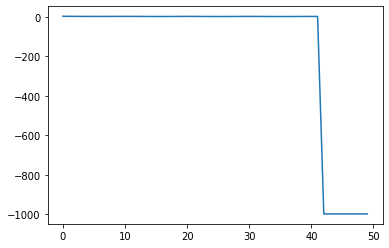

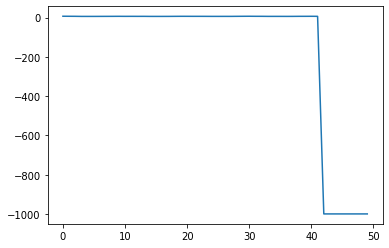

In [ ]:
np.save('vali_liss.npy',vali_loss)
np.save('train_liss.npy',train_loss)
plt.figure(1)
plt.plot(train_loss)
plt.figure(2)
plt.plot(vali_loss)
plt.show()

In [ ]:
maps = np.array(maps)
Maps = np.mean(maps,axis = 1)
plt.plot(Maps)
plt.title('mean mAP vs epoch')
plt.savefig('mAP.png')
plt.show()
print('MAX mAP',max(Maps))

AxisError: axis 1 is out of bounds for array of dimension 1

: 